# Jimi Togni - RA: 226359

--------------------------------------------------

## Parte 1 - Atividade teorica

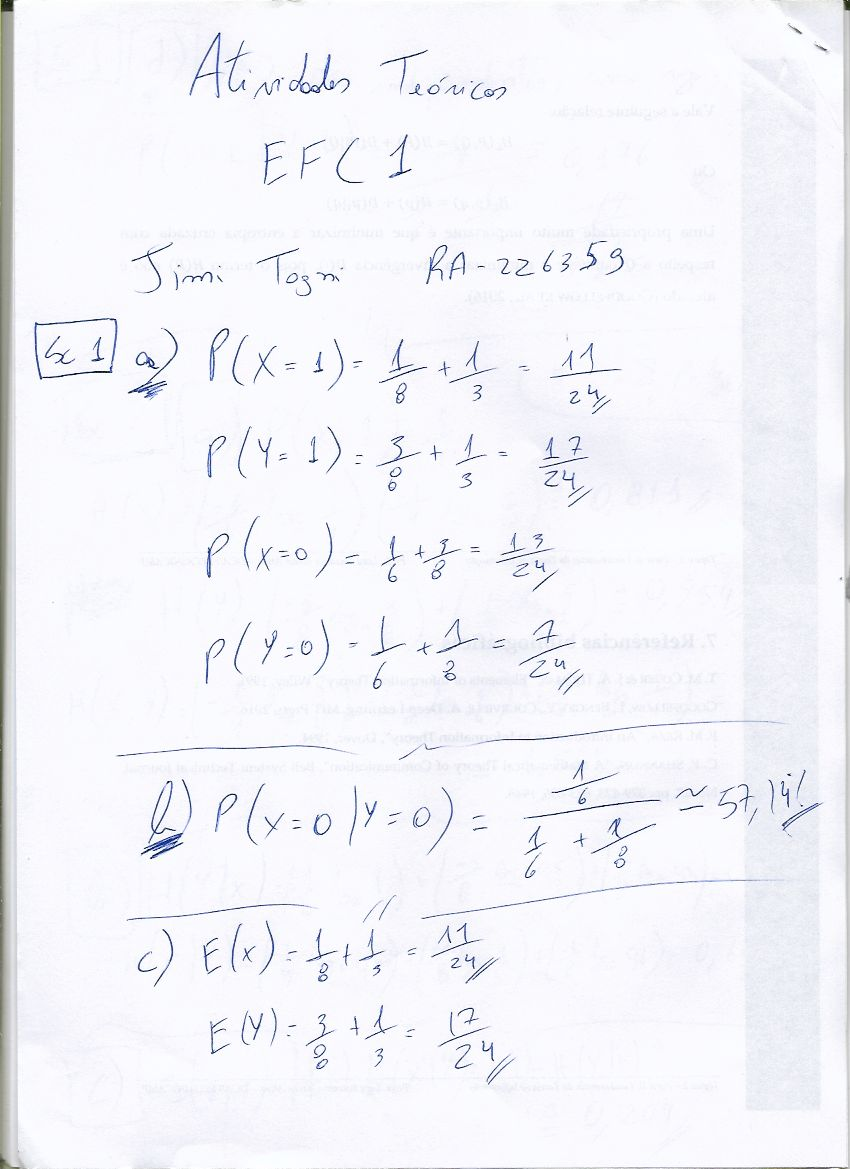

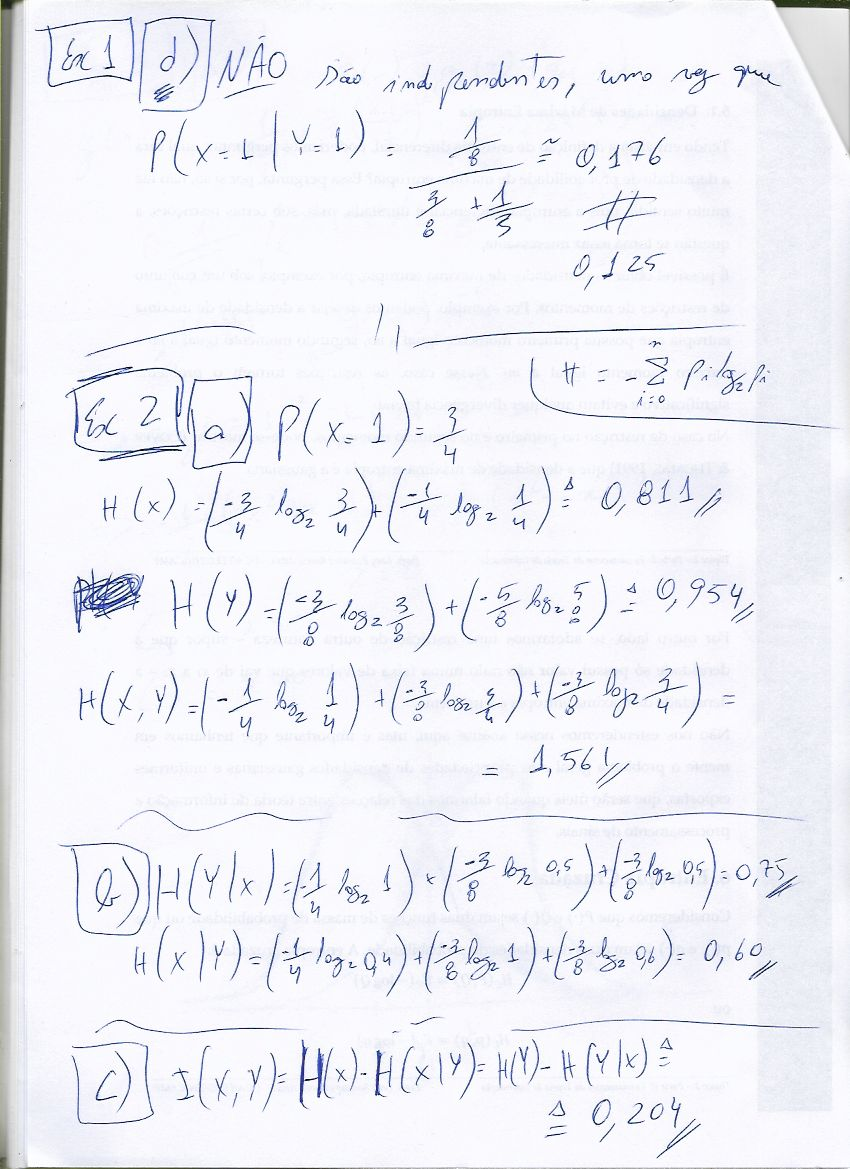

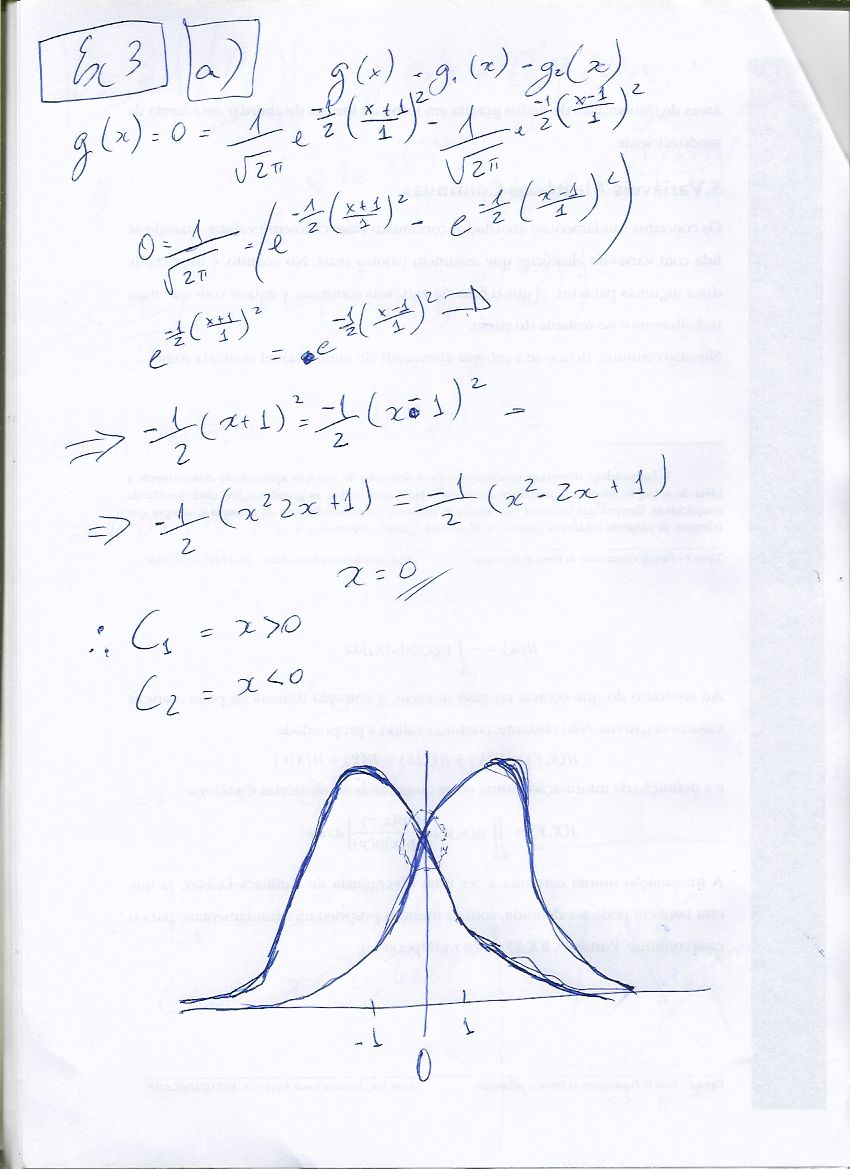

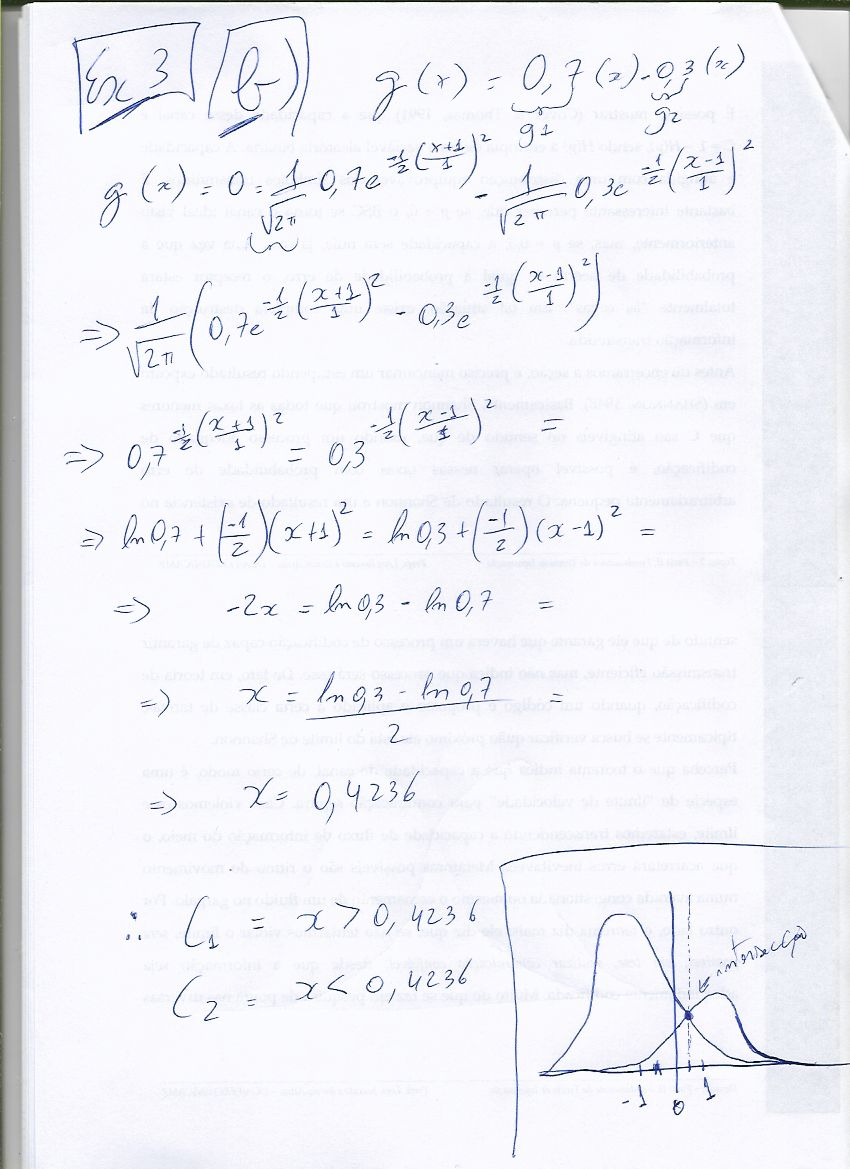

In [5]:
from PIL import Image
path1 = "teorico_1.jpeg"
display(Image.open(path))

path2 = "teorico_2.jpeg"
display(Image.open(path2))

path3 = "teorico_3.jpeg"
display(Image.open(path3))

path4 = "teorico_4.jpeg"
display(Image.open(path4))

---

## Parte 2 – Atividade computacional

---

In [5]:
#importando pacotes essenciais

import numpy as np
import dateutil.parser as parse
import pandas as pd
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
import csv
import datetime
from datetime import *

#plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [6]:
#funcoes

def convert(dt, tmp):
    date = datetime.strptime(dt, "%Y-%m-%d")
    return (
        datetime.strftime(date, "%d/%m/%Y"),
        float(tmp),
        datetime.timestamp(date),
        float(tmp),
        date.day,
        date.month,
        date.year,
    )


def import_data():
    data = None
    with open('daily-minimum-temperatures.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        data = [convert(*row) for i, row in enumerate(csv_reader) if i > 0]
    return np.array(data)


def kfold(data, k=1, shuffle=True):
    # np.split(x, 3)
    k = k + 1
    folds = []
    if shuffle:
        permutation = np.random.permutation(data.shape[0])
        data = data[permutation, :]
    
    mb = np.ceil(data.shape[0] / k).astype(np.int32)
    for r, _ in enumerate(range(k)):
        ini, end = r * mb, mb * (r+1)
        folds.append(data[ini:end, :])
    return np.array(folds)


class Scaler:
    
    def __init__(self):
        self._mu = 0
        self._std = 0
    
    def fit(self, x):
        self._mu = np.mean(x)
        self._std = np.std(x)
    
    def transform(self, x):
        y = np.copy(x)
        return (y - self._mu) / self._std
    
    def inverse(self, x):
        y = np.copy(x)
        return (y * self._std) + self._mu
    
    def __repr__(self):
        return f"{self._mu}, {self._std}"
    

class Normalizer:
    
    def __init__(self):
        self._min = 0
        self._max = 0
    
    def fit(self, x):
        self._min = np.min(x)
        self._max = np.max(x)
    
    def transform(self, x):
        y = np.copy(x)
        return (y - self._min) / (self._max - self._min)

    def inverse(self, x):
        y = np.copy(x)
        return (y * (self._max - self._min)) + self._min 
        
    def __repr__(self):
        return f"{self._min}, {self._max}"


class LinearRegressionImpl:
    
    def __init__(self, fit_intercept=True, reg=1e-20, weights=None):
        self.w = weights
        self.fit_intercept = fit_intercept
        self._reg = reg
    
    def mse(self, y, yh):
        N = y.shape[0]
        L2 = (self._reg / (2 * N)) * np.sum([np.sum(np.square(w)) for w in self.w])
        return ((1 / N) * np.sum(np.square(y - yh))) + L2
    
    def _correct_X(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return X
    
    def train(self, X, y):
        X = self._correct_X(X)
        
        pinv = np.dot(X.T, X)
        reg = np.eye(pinv.shape[0], dtype=int) * self._reg
        reg[0][0] = 1
        nX = np.dot(np.linalg.inv(pinv + reg), X.T)
        self.w = np.dot(nX, y)
        
        yh = np.dot(X, self.w)
        J = self.mse(y, yh)
        return self, J
    
    def predict(self, X):
        X = self._correct_X(X)
        return np.dot(X, self.w)


class PolynomialRegressionImpl(LinearRegressionImpl):
    
    def __init__(self, fit_intercept=True, reg=1e-20, weights=None, degree=1):
        super().__init__(fit_intercept, reg, weights)
        self.degree = degree
        
    def _correct_X(self, X):
        M = np.copy(X)
        for degree in range(2, self.degree):
            M = np.c_[M, np.power(X, degree)]
        X = np.copy(M)
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return X

**Ultimos 10 registros da base de dados.**

In [7]:
data = import_data()
df_data = np.copy(data)
data = data[:, 2:].astype(np.float32)

dts = pd.DataFrame(df_data)
dts1990 = dts[dts[0].str.contains("1990")]
dts1990 = dts1990[dts1990[0].str.contains("(01\/)(01|02|03|04|05|06|07|08|09|10|11|12)", regex=True)]

dts = dts[dts[0].str.contains("01/01")]

df = pd.DataFrame(df_data[:, 0:2], columns=["Data", "Temperature"]).tail(10)
print(df)#.style.hide_index()

            Data Temperature
3640  22/12/1990        13.2
3641  23/12/1990        13.9
3642  24/12/1990        10.0
3643  25/12/1990        12.9
3644  26/12/1990        14.6
3645  27/12/1990        14.0
3646  28/12/1990        13.6
3647  29/12/1990        13.5
3648  30/12/1990        15.7
3649  31/12/1990        13.0


/home/jimitogni/.local/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


**Grafico de toda a base de dados.**

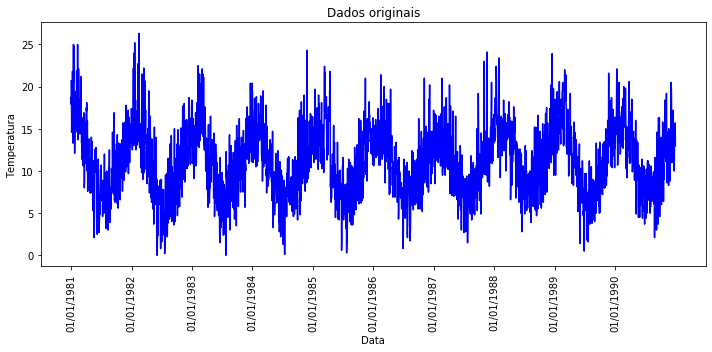

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(data[:, 0], data[:, 1], color="blue")
plt.title("Dados originais")
plt.xticks(dts[2].to_numpy().astype(np.float32), dts[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.tight_layout()
plt.show()

**Divisão dos dados para treinamento e, o ultimo ano, para teste.**

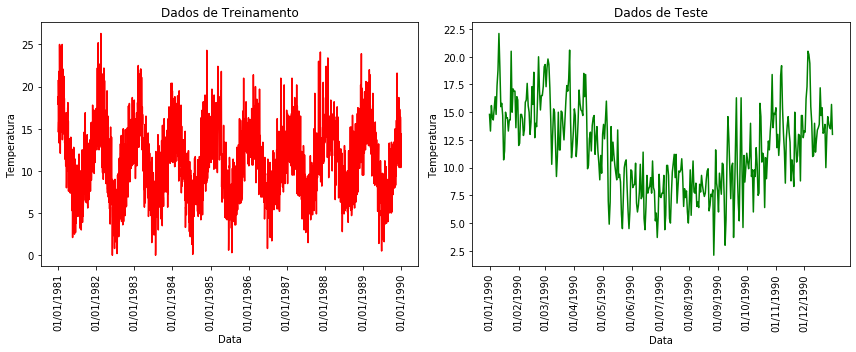

In [9]:
dt_1990 = datetime.timestamp(datetime.strptime("1990-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"))
train, test = data[data[:, 0] < dt_1990], data[data[:, 0] >= dt_1990]

X_train, y_train = train[:, 2:], train[:, 1]
X_test, y_test = test[:, 2:], test[:, 1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train[:, 0], y_train, 'r')
plt.title("Dados de Treinamento")
plt.xticks(dts[2].to_numpy().astype(np.float32), dts[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.subplot(1, 2, 2)
plt.plot(test[:, 0], y_test, 'g')
plt.title("Dados de Teste")
plt.xticks(dts1990[2].to_numpy().astype(np.float32), dts1990[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.tight_layout()
plt.show()

**Para evitar sobreajuste, foi utilizada a tecnica de k-fold, que resumidamente, consiste em de divisoes do dataset de treinamento e validacao em partes menores, o grafico abaixo demonstra a distribuicao para uma das 10  pastas**

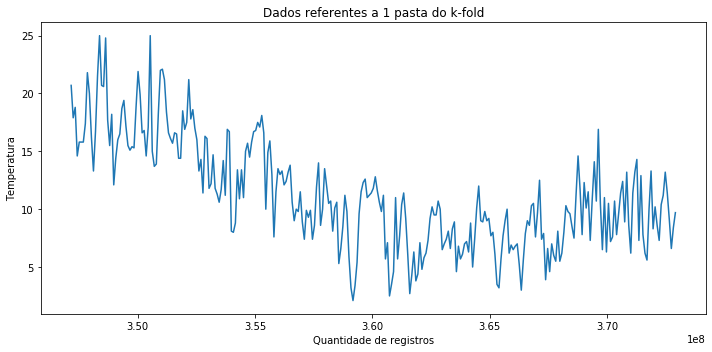

In [10]:
folds = kfold(train, k=10, shuffle=False)

plt.figure(figsize=(10, 5))
plt.title("Dados referentes a 1 pasta do k-fold")
plt.xlabel("Quantidade de registros")
plt.ylabel("Temperatura")
plt.plot(folds[0][:, 0], folds[0][:, 1])
plt.tight_layout()
plt.show()

#### **Exercício 1**

Estipulando o range para os `k` atrasos 

In [11]:
alld = data[:, 1]
nmin = np.round(np.min(alld).astype(np.float), 2)
nmax = np.round(np.max(alld).astype(np.float)*0.94, 2)

print("Valores:")
print(f"Min: {nmin}, Max: {nmax}")

Valores:
Min: 0.0, Max: 24.72


Executando a Regressão Linear, com K variando de 1 a 30 e k-fold variando de 1 a 20 folds

Resultados:

In [12]:
def sparse_temporal_data(data, nmin, nmax):
    dados = data[:, 1]
    size = len(dados)
    std = []
    for k in range(1, 31):
        x = []
        for i in range(size):
            r = 0 if i-k < 0 else i-k
            ds = dados[r:i]
            if len(ds) < k:
                # np.random.rand
                before = np.round(np.random.uniform(nmin, nmax, size=(k-len(ds), )), 2)
                # np.zeros((k-len(ds), ), dtype=np.float32)
                ds = np.concatenate((before, ds))
            x.append(np.concatenate((ds, np.array([dados[i]]))))
        std.append(x)
    return std

train_k = sparse_temporal_data(train, nmin, nmax)
test_k = sparse_temporal_data(test, nmin, nmax)

In [13]:
J_k = []
for k in range(1, 31):
    for kf in range(1, 19):
        folds = kfold(np.array(train_k[k-1]), k=kf, shuffle=False)
        J = []
        better_J = 1e+10
        kf_val = 0
        for i in range(0, kf):
            # Validation set
            X_val, y_val = folds[i][:, :k], folds[i][:, k]
            # Training set
            nF = np.append(folds[i+1:, ], folds[:i, ], axis=0)
            X, y = nF[0][:, :k], nF[0][:, k]
            # Train
            linreg, _ = LinearRegressionImpl().train(X, y)
            # Predict
            yh = linreg.predict(X_val)
            # MSE
            e = linreg.mse(y_val, yh)
            J.append(e)
            if e < better_J:
                kf_val = i
                better_J = e
        J_k.append((k, kf, kf_val, np.mean(J), folds))
J_k = np.array(J_k)

In [14]:
best_result = None
best_J = 1e+10
for m in range(1, 31):
    c = J_k[(J_k[:, 0] == m)]
    mean = np.mean(c[:, 3])
    if best_J > mean:
        best_J = mean
        best_result = c[c[:, 3] == np.min(c[:, 3])][0]

Melhores valores encontrados:
K:  10
k-fold:  3


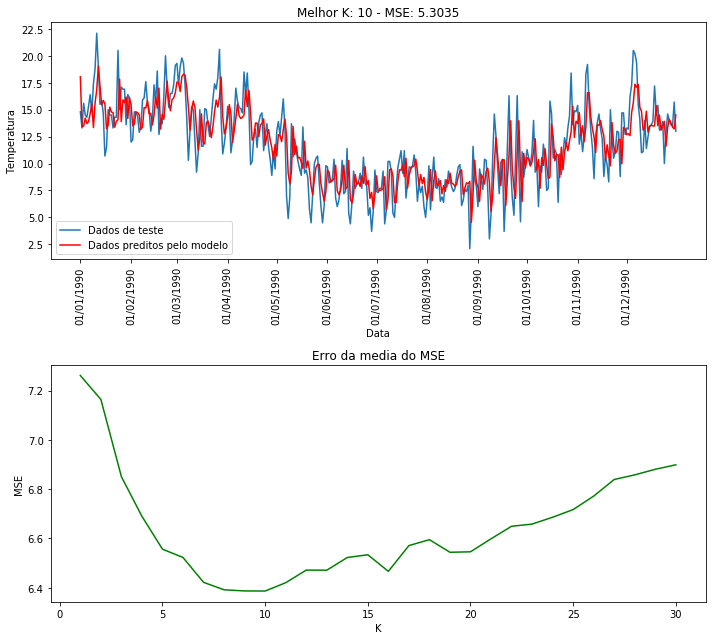

In [15]:
# Encontramos o melhor K e Validation Set.
k, ft, i, mse, folds = best_result
k = int(k)
print("Melhores valores encontrados:")
print("K: ", k)
print("k-fold: ", ft)

minor_J0 = 1e+10
best_weights = None
# Validation set
X_val, y_val = folds[i][:, :k], folds[i][:, k]
# Training set
nF = np.append(folds[i+1:, ], folds[:i, ], axis=0)
X, y = nF[0][:, :k], nF[0][:, k]
# Train
linreg, _ = LinearRegressionImpl().train(X, y)
best_weights = linreg.w

# Running again for the best result
lr = LinearRegressionImpl(weights=best_weights)
test_f = np.array(test_k[k-1])
X_test, y_test = test_f[:, :k], test_f[:, k]
yh_test = lr.predict(X_test)
mse = lr.mse(y_test, yh_test)

# Data table
df = pd.DataFrame([Jk[:4] for Jk in J_k], columns=["K", "k-fold", "Fold de Validacao", "Média MSE"])
df["Fold de Validacao"] += 1

k_mse_mean = []
for m in range(1, 31):
    c = J_k[(J_k[:, 0] == m)]
    k_mse_mean.append(np.mean(c[:, 3]))

plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
plt.title(f"Melhor K: {k} - MSE: {np.round(mse, 4)}")
plt.xticks(dts1990[2].to_numpy().astype(np.float32), dts1990[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.plot(test[:, 0], y_test, label="Dados de teste")
plt.plot(test[:, 0], yh_test, 'r', label="Dados preditos pelo modelo")
plt.legend()
plt.subplot(2, 1, 2)
plt.title(f"Erro da media do MSE")
plt.xlabel("K")
plt.ylabel("MSE")
plt.plot(np.arange(1, 31), k_mse_mean, "g")
plt.tight_layout()
plt.show()

**No primeiro gráfico, pode-se observar o resultado do modelo, utilizando para o hiperparâmetro k = 9, o erro médio com MSE = 5.261.**

**No segundo gráfico é demonstrada a variação do MSE ao longo das 30 pastas.**


**Demonstra-se na tabela a baixo, 10 resultados apos as iteracoes.**



In [16]:
df = df.sort_values(by=["Média MSE", "K"]).head(10)
# df.style.hide_index()
print(df)

      K  k-fold  Fold de Validacao  Média MSE
272  16       3                  3   6.089827
344  20       3                  3   6.134077
149   9       6                  6   6.136854
164  10       3                  3   6.140731
275  16       6                  6   6.141052
167  10       6                  6   6.142182
146   9       3                  3   6.143191
182  11       3                  3   6.148155
131   8       6                  6   6.149971
308  18       3                  3   6.153620


##############################################

#### **Exercício 2**


**Para a quantidade de atributos gerados, vamos utilizar 100 iterações, com uma distribuição uniforme que variou de -1 até 1.**

**OS valores do lambda variaram de 1e+1 - 1e-4**

**Para a normalização, os dados foram enquadrados entre os valores mínimo e máximo, obtidos anteriormente.**

**Os valores de K estão entre 7 a 22, e o K-Fold utilizado foi de 1 até 10 folds.**


In [17]:
all_data = np.concatenate((np.copy(train[:, 1]), np.copy(test[:, 1])))

scaler = Scaler()
scaler.fit(all_data)

normalizer = Normalizer()
normalizer.fit(all_data)

N_k = 13
N_T = 101

reg = np.array([
    1e+1, 1e+0, 1e-1, 1e-2, 1e-3, 1e-4
])
N_R = len(reg)

print(f"{len(reg)} valores para o lambda -> {(reg)}")

6 valores para o lambda -> [1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04]


In [18]:
#import cupy as cp
import time

def gpu(x, w):
    x = np.asarray(x)
    x = np.tanh(np.dot(x, w))
    return x

fold_N, fold_val, pas = 0, 0, 0
J_k = []
for k in range(7, 23):
    
    #print(f"1 for k = {k}")
    start = time.time()
    pas += 1
    for kf in range(1, N_k):
        #print(f"1 for kf = {kf}")
        folds = kfold(np.array(train_k[k-1]), k=kf, shuffle=False)
        for T in range(N_T):
            #print(f"1 for T = {T}")
            best_reg = 1e-10
            val_fold = 0
            best_w = None
            J = []
            better_J = 1e+10
            for r in range(N_R):
                #print(f"1 for r = {r}")
                # Weights
                w = np.random.uniform(-1, 1, size=(k, T + 1)) * np.sqrt(1 / (k + T + 1))
                for i in range(kf):
                    #print(f"1 for i = {i}")
                    # Regularization
                    regu = reg[r]

                    # Validation set
                    X_val, y_val = folds[i][:, :k], folds[i][:, k]
                    X_val = normalizer.transform(X_val)
                    X_val = gpu(X_val, w)

                    # Training set
                    nF = np.append(folds[i+1:, ], folds[:i, ], axis=0)
                    X, y = nF[0][:, :k], nF[0][:, k]
                    X = normalizer.transform(X)
                    X = gpu(X, w)

                    # Train
                    linreg, _ = LinearRegressionImpl(reg=regu).train(X, y)
                    # Predict
                    yh = linreg.predict(X_val)
                    # MSE
                    e = linreg.mse(y_val, yh)
                    # Hold information
                    J.append(e)
                    if e < better_J:
                        val_fold = i
                        best_w = w
                        best_reg = regu
                        better_J = e
            J_k.append((k, kf, val_fold, T + 1, best_reg, np.mean(J), best_w, folds))
    print(f"{pas} -> K: {k}")
J_k = np.array(J_k)

1 -> K: 7
2 -> K: 8
3 -> K: 9
4 -> K: 10
5 -> K: 11
6 -> K: 12
7 -> K: 13
8 -> K: 14
9 -> K: 15
10 -> K: 16
11 -> K: 17
12 -> K: 18
13 -> K: 19
14 -> K: 20
15 -> K: 21
16 -> K: 22


In [19]:
best_result = None
best_T_J = 1e+10
best_w = None
for m in range(1, N_T):
    c = J_k[(J_k[:, 3] == m)]
    mean = np.mean(c[:, 5])
    if best_T_J > mean:
        min_J = np.min(c[:, 5])
        h = c[c[:, 5] == min_J]
        T, reg = m, h[:, 4][0]
        best_T_J = mean
        best_result = J_k[(J_k[:, 3] == m) & (J_k[:, 4] == reg)][0]

In [20]:
# Encontramos o melhor K e Validation Set.
k, kf, i, T, reg, mse, best_w, folds = best_result
k = int(k)

print("Melhores resultados obtidos:")
print("k-fold: ", kf)
print("K'atrasos': ", k)
print("T: ", T)
print("lambda: ", reg)
print("MSE: ", mse)

# Training set
nF = np.append(folds[i+1:, ], folds[:i, ], axis=0)
X, y = nF[0][:, :k], nF[0][:, k]
Xl = normalizer.transform(X)
Xl = np.tanh(np.dot(Xl, best_w))

# Train
linreg, _ = LinearRegressionImpl(reg=reg).train(Xl, y)
best_weights = linreg.w

# Running again for the best result
test_f = np.array(test_k[k-1])
X_test, y_test = test_f[:, :k], test_f[:, k]
Xl_test = normalizer.transform(X_test)
Xl_test = np.tanh(np.dot(Xl_test, best_w))

lr = LinearRegressionImpl(reg=reg, weights=best_weights)
yh_test = lr.predict(Xl_test)
mse = lr.mse(y_test, yh_test)

Melhores resultados obtidos:
k-fold:  1
K'atrasos':  7
T:  100
lambda:  0.001
MSE:  6.781135327191719


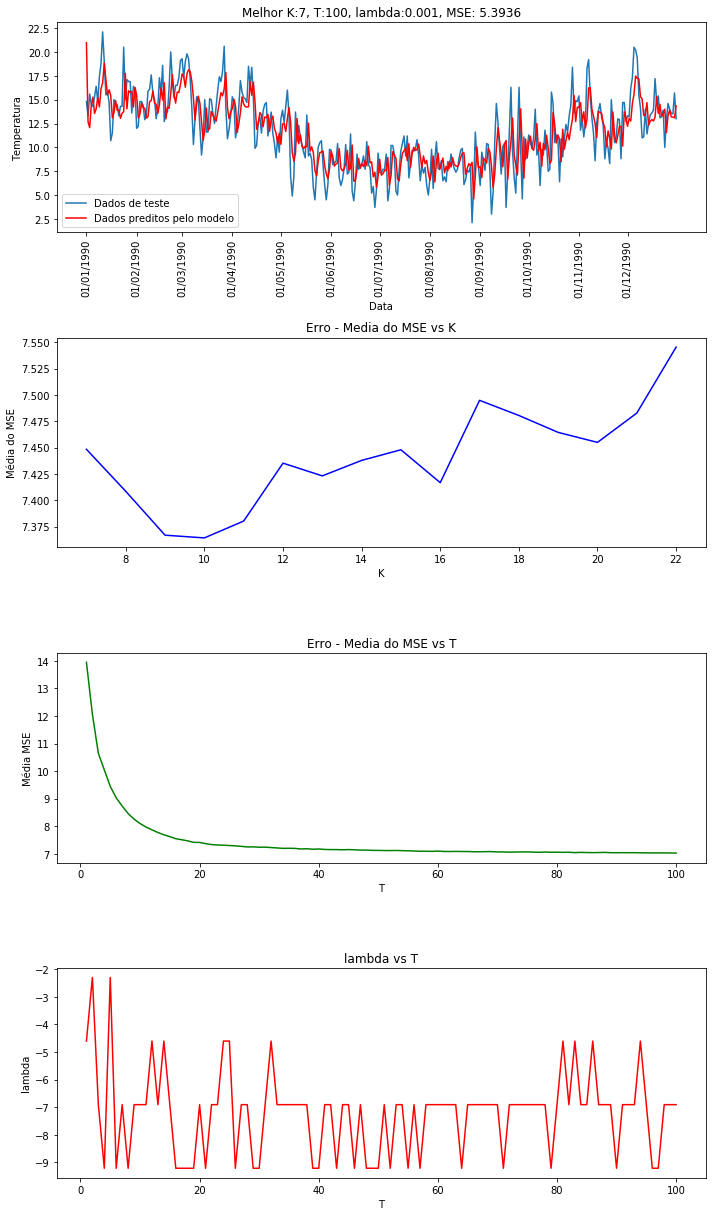

In [21]:
# Data table
df = pd.DataFrame([Jk[:6] for Jk in J_k], columns=["K", "K-Fold", "Fold de Validacao", "T", 
                                                   "Regularizacao", "Média MSE"]) #ver se da pra mudar aqui

k_mse_mean = []
for m in range(7, 23):
    c = J_k[(J_k[:, 0] == m)]
    k_mse_mean.append(np.mean(c[:, 5]))

T_mse_mean, reg_min = [], []
for m in range(1, N_T):
    c = J_k[(J_k[:, 3] == m)]
    T_mse_mean.append(np.mean(c[:, 5]))
    min_J = np.min(c[:, 5])
    h = c[c[:, 5] == min_J]
    reg_min.append(h[:, 4][0])

plt.figure(figsize=(10, 17))
plt.subplot(4, 1, 1)
plt.title(f"Melhor K:{k}, T:{T}, lambda:{reg}, MSE: {np.round(mse, 4)}")
plt.xticks(dts1990[2].to_numpy().astype(np.float32), dts1990[0].to_numpy(), rotation=90)
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.plot(test[:, 0], y_test, label="Dados de teste")
plt.plot(test[:, 0], yh_test, 'r', label="Dados preditos pelo modelo")
plt.legend()
plt.subplot(4, 1, 2)
plt.title(f"Erro - Media do MSE vs K")
plt.xlabel("K")
plt.ylabel("Média do MSE")
plt.plot(range(7, 23), k_mse_mean, "b")
plt.subplot(4, 1, 3)
plt.title(f"Erro - Media do MSE vs T")
plt.xlabel("T")
plt.ylabel("Média MSE")
plt.plot(range(1, N_T), T_mse_mean, "g")
plt.subplot(4, 1, 4)
plt.title(f"lambda vs T")
plt.xlabel("T")
plt.ylabel("lambda")
plt.plot(range(1, N_T), np.log(reg_min), "r")

plt.tight_layout()
plt.show()

**Os dados obtidos após a passagem pelo segundo modelo de regressão linear foram:**

In [22]:
df = df.sort_values(by=["Média MSE", "T", "K"]).head(10)
print(df)

        K  K-Fold  Fold de Validacao    T  Regularizacao  Média MSE
11209  16       3                  2  100         0.0010   6.559195
11210  16       3                  2  101         0.0010   6.568269
16054  20       3                  2   97         0.0001   6.570826
11207  16       3                  2   98         0.0010   6.572356
16055  20       3                  2   98         0.0100   6.581017
11196  16       3                  2   87         0.0010   6.582181
15956  20       2                  1  100         0.0010   6.583036
16040  20       3                  2   83         0.0100   6.584339
11191  16       3                  2   82         0.0010   6.585271
11200  16       3                  2   91         0.0010   6.589652


**Observa-se que, nos dois modelos implementados nesta lista de exercícios, ambos apresentaram resultados aproximados em relação ao erro médio e a predição dos dados, porém, o ganho de acurácia no segundo modelo, foi visivelmente melhor**